In [5]:
import torch
from torch.utils.data import DataLoader
from dataset import YoloDarknetDataset
from model import model_builder
import lightnet as ln
from test_script import test_step
from utils import plot_result, RGBDCustomTransform, RGBCustomTransform, DepthCustomTransform, show_sample, DepthCustomTransform, load_config, to_xyxy_coords, draw_bounding_boxes

In [6]:
config = load_config("configs/train_anyv2_local_pavic.yaml")


BASE_DIR = config["base_dir"]
TRAIN_IMG_DIR = config["train_img_dir"]
TRAIN_DEPTH_DIR = config["train_depth_dir"]
TRAIN_LABEL_DIR =  config["train_label_dir"]
BATCH_SIZE = config["batch_size"]
NUM_WORKERS = config["num_workers"]
LEARNING_RATE = config["learning_rate"]
NUM_EPOCHS = config["num_epochs"]
MODEL_TYPE = config["model_type"]
FUSE_LAYER = config["fuse_layer"]
DATASET_NAME = config["dataset_name"]
TEST_IMG_DIR = config["test_img_dir"]
TEST_DEPTH_DIR = config["test_depth_dir"]
TEST_LABEL_DIR = config["test_label_dir"]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3

TRAIN_IMG_DIR =  BASE_DIR + TRAIN_IMG_DIR
TRAIN_DEPTH_DIR = BASE_DIR + TRAIN_DEPTH_DIR
TRAIN_LABEL_DIR = BASE_DIR + TRAIN_LABEL_DIR

In [12]:
print(f"Using Configuration \n{config}")
print(f"Using Device {DEVICE}")


model = model_builder(num_classes=NUM_CLASSES, model_type=MODEL_TYPE, fuse_layer=FUSE_LAYER)
model.load("models/anythingv2_best.pth")
model.to("cpu")

loss_fn = ln.network.loss.RegionLoss(
    num_classes= model.num_classes,
    anchors=model.anchors,
    network_stride=model.stride
)

test_transforms = RGBDCustomTransform(resize_size=(416, 416), flip_prob=0)

test_dataset = YoloDarknetDataset(
    images_dir=TEST_IMG_DIR,
    depth_dir=TEST_DEPTH_DIR,
    labels_dir=TEST_LABEL_DIR,
    classes=["Cyclist", "Pedestrian", "Car"],
    transform=test_transforms,
    model_type=MODEL_TYPE
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Using Configuration 
{'dataset_name': 'anythingv2_newsplit', 'base_dir': '/home/gkmo/workspace/data', 'train_img_dir': '/home/gustavo/workstation/depth_estimation/data/new_splits/train/images/', 'train_depth_dir': '/home/gustavo/workstation/depth_estimation/data/new_anything_split/train/', 'train_label_dir': '/home/gustavo/workstation/depth_estimation/data/new_splits/train/labels/', 'val_img_dir': '/home/gustavo/workstation/depth_estimation/data/new_splits/val/images/', 'val_depth_dir': '/home/gustavo/workstation/depth_estimation/data/new_anything_split/val/', 'val_label_dir': '/home/gustavo/workstation/depth_estimation/data/new_splits/val/labels/', 'test_img_dir': '/home/gustavo/workstation/depth_estimation/data/new_splits/test/images/', 'test_depth_dir': '/home/gustavo/workstation/depth_estimation/data/new_anything_split/test/', 'test_label_dir': '/home/gustavo/workstation/depth_estimation/data/new_splits/test/labels/', 'batch_size': 16, 'num_workers': 16, 'learning_rate': 0.01, 'num

In [13]:
do_test = True
if do_test:
    metric_map, test_loss= test_step(
        model=model,
        dataloader=test_dataloader,
        batch_size=BATCH_SIZE,
        loss_fn=loss_fn,
        device=DEVICE
    )

    print(f"mAP | AP {metric_map}")
    print(f"Test Loss: {test_loss}")

mAP | AP (0.3360679546991984, [0.2282174676656723, 0.14320053160190582, 0.6367858648300171])
Test Loss: 2.0468614393092217


In [ ]:
plot_result(model=model, test_dataset=test_dataset, index=3)

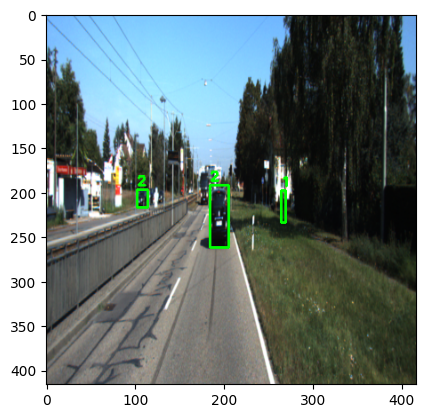

In [46]:
show_sample(test_dataset, 3, "rgb")